# Analysis of SpecletThree

This notebook analyzes the MCMC and ADVI fit of the SpecletThree model.
Below are some questions to address and aspects of the model to dig into:

1. Compare the parameter values between ADVI and MCMC.
2. Are there correlations between the parameter values?
3. Analyze the posterior predictions LOO values.
4. How do the model fits compare between the models with and without a covariate for *KRAS*?
5. Which genes change the most by the addition of the *KRAS* covariate?
6. How do the parameter values in this model compare to those from DepMap?

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import string
import warnings
from pathlib import Path
from time import time

import arviz as az
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns
from theano import tensor as tt

In [6]:
from src.data_processing import achilles as achelp
from src.data_processing import common as dphelp
from src.io import cache_io
from src.loggers import logger
from src.modeling import pymc3_analysis as pmanal
from src.modeling import pymc3_sampling_api as pmapi
from src.models.speclet_three import SpecletThree
from src.plot.color_pal import FitMethodColors, ModelColors, SeabornColor

In [7]:
notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(
    gg.theme_bw()
    + gg.theme(
        figure_size=(4, 4),
        axis_ticks_major=gg.element_blank(),
        strip_background=gg.element_blank(),
    )
)
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 127
np.random.seed(RANDOM_SEED)

HDI_PROB = 0.89

eb = gg.element_blank()

In [8]:
model_name = "SpecletThree-debug"
sp3 = SpecletThree(
    model_name,
    root_cache_dir=cache_io.default_cache_dir(),
    debug=True,
    kras_cov=False,
)

sp3.build_model()
if sp3.cache_manager.mcmc_cache_exists():
    _ = sp3.mcmc_sample_model()
else:
    logger.error("Could not find model.")

[05/25/21 14:30:22] INFO     Calling `model_specification()` method.     ]8;id=1621967422.9196525-715326;file:///n/data2/dfci/cancerbio/haigis/Cook/speclet/src/models/speclet_model.py\speclet_model.py]8;;\:167

                    INFO     Beginning PyMC3 model specification.        ]8;id=1621967422.9261603-425998;file:///n/data2/dfci/cancerbio/haigis/Cook/speclet/src/models/speclet_three.py\speclet_three.py]8;;\:112

[05/25/21 14:30:23] WARNING  Dropping data points of sgRNA that    ]8;id=1621967423.700783-864583;file:///n/data2/dfci/cancerbio/haigis/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:125
                             map to multiple genes.

                    WARNING  Dropping data points with missing     ]8;id=1621967423.73245-808723;file:///n/data2/dfci/cancerbio/haigis/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:131
                             copy number.

                    INFO     Getting Theano shared variables.            ]8;id=1621967423.8084185-545734;file:///n/data2/dfci/cancerbio/haigis/Cook/speclet/src/models/speclet_three.py\speclet_three.py]8;;\:119

                    INFO     Creating PyMC3 model.                       ]8;id=1621967423.8175573-381498;file:///n/data2/dfci/cancerbio/haigis/Cook/speclet/src/models/speclet_three.py\speclet_three.py]8;;\:127

[05/25/21 14:30:42] INFO     ArvizCacheManager: MCMC cache exists.      ]8;id=1621967442.0433671-549041;file:///n/data2/dfci/cancerbio/haigis/Cook/speclet/src/managers/cache_managers.py\cache_managers.py]8;;\:273

                    INFO     ArvizCacheManager: MCMC cache exists.      ]8;id=1621967442.0478568-877102;file:///n/data2/dfci/cancerbio/haigis/Cook/speclet/src/managers/cache_managers.py\cache_managers.py]8;;\:273

                    INFO     Returning results from cache.               ]8;id=1621967442.0507889-802047;file:///n/data2/dfci/cancerbio/haigis/Cook/speclet/src/models/speclet_model.py\speclet_model.py]8;;\:264

                    INFO     ArvizCacheManager: MCMC cache exists.      ]8;id=1621967442.0534027-614937;file:///n/data2/dfci/cancerbio/haigis/Cook/speclet/src/managers/cache_managers.py\cache_managers.py]8;;\:273

In [9]:
model_name_kras = "SpecletThree-kras-debug"
sp3_kras = SpecletThree(
    model_name_kras,
    root_cache_dir=cache_io.default_cache_dir(),
    debug=True,
    kras_cov=True,
)

sp3_kras.build_model()
if sp3_kras.cache_manager.mcmc_cache_exists():
    _ = sp3_kras.mcmc_sample_model()
else:
    logger.error("Could not find model.")

[05/25/21 14:30:54] INFO     Calling `model_specification()` method.     ]8;id=1621967454.7677426-606677;file:///n/data2/dfci/cancerbio/haigis/Cook/speclet/src/models/speclet_model.py\speclet_model.py]8;;\:167

                    INFO     Beginning PyMC3 model specification.        ]8;id=1621967454.7712648-497256;file:///n/data2/dfci/cancerbio/haigis/Cook/speclet/src/models/speclet_three.py\speclet_three.py]8;;\:112

                    INFO     Getting Theano shared variables.            ]8;id=1621967454.84969-780263;file:///n/data2/dfci/cancerbio/haigis/Cook/speclet/src/models/speclet_three.py\speclet_three.py]8;;\:119

                    INFO     Creating PyMC3 model.                       ]8;id=1621967454.8537178-503003;file:///n/data2/dfci/cancerbio/haigis/Cook/speclet/src/models/speclet_three.py\speclet_three.py]8;;\:127

[05/25/21 14:30:56] INFO     ArvizCacheManager: MCMC cache exists.      ]8;id=1621967456.5097435-240670;file:///n/data2/dfci/cancerbio/haigis/Cook/speclet/src/managers/cache_managers.py\cache_managers.py]8;;\:273

                    INFO     ArvizCacheManager: MCMC cache exists.      ]8;id=1621967456.5127306-859689;file:///n/data2/dfci/cancerbio/haigis/Cook/speclet/src/managers/cache_managers.py\cache_managers.py]8;;\:273

                    INFO     Returning results from cache.               ]8;id=1621967456.5152063-941696;file:///n/data2/dfci/cancerbio/haigis/Cook/speclet/src/models/speclet_model.py\speclet_model.py]8;;\:264

                    INFO     ArvizCacheManager: MCMC cache exists.      ]8;id=1621967456.517959-163162;file:///n/data2/dfci/cancerbio/haigis/Cook/speclet/src/managers/cache_managers.py\cache_managers.py]8;;\:273

In [10]:
sp3.model

In [11]:
sp3_kras.model

## Fitting diagnositcs

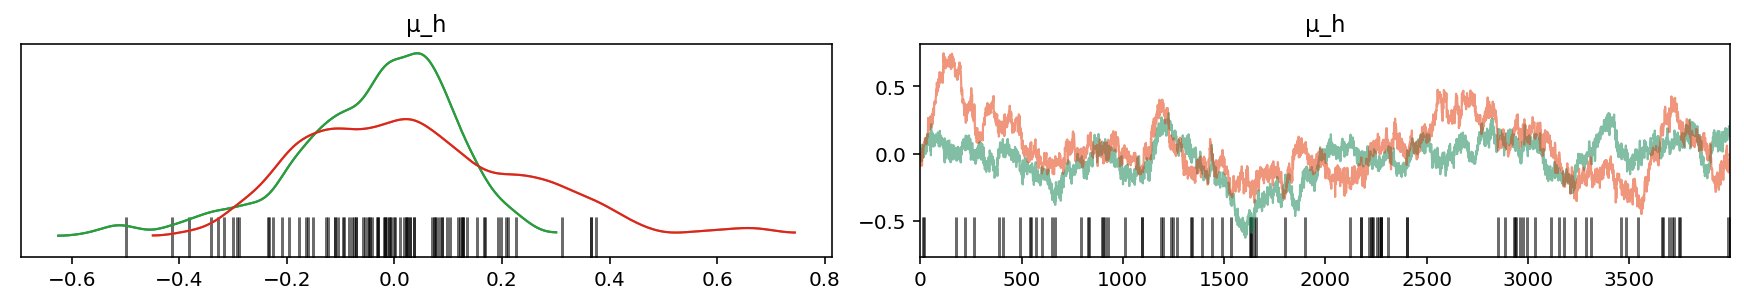

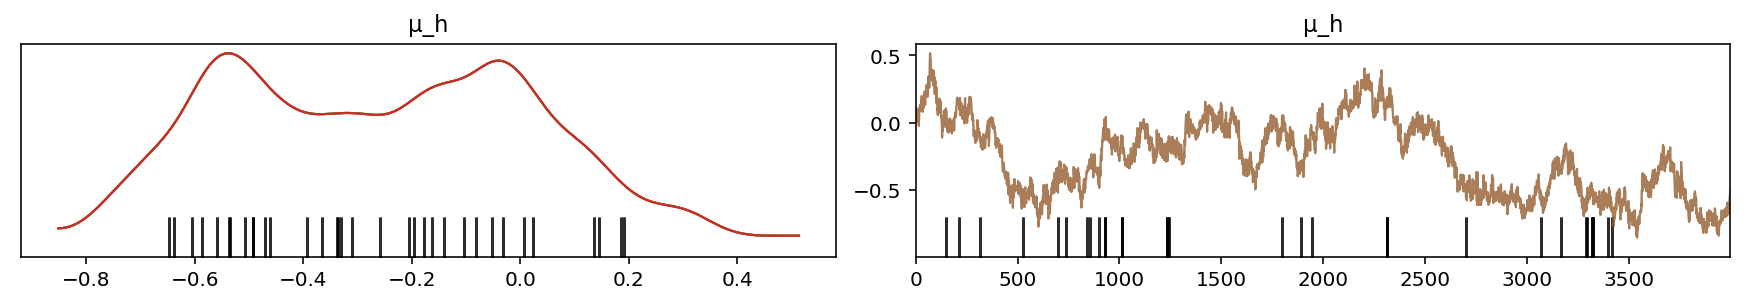

In [12]:
for sp3_model in [sp3, sp3_kras]:
    az.plot_trace(sp3_model.mcmc_results, var_names="μ_h", compact=False);

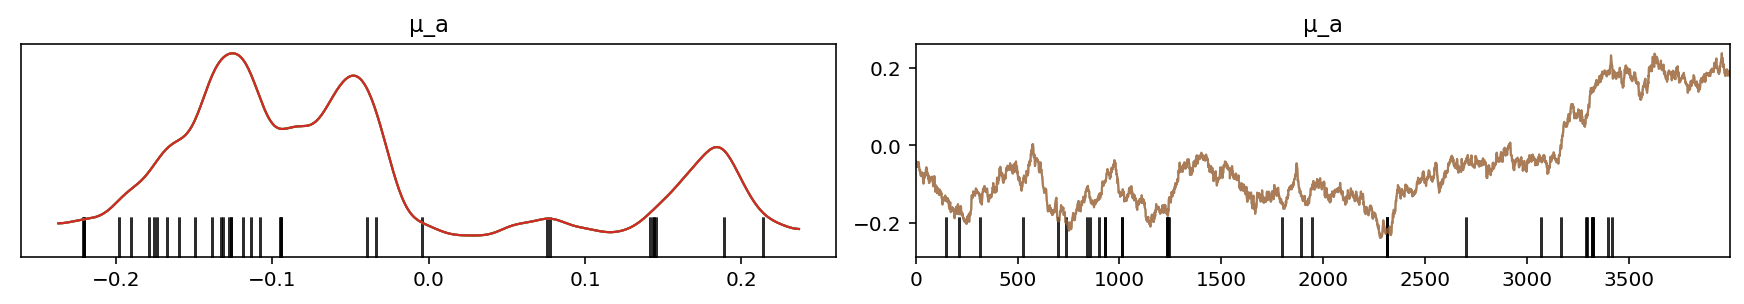

In [13]:
az.plot_trace(sp3_kras.mcmc_results, var_names="μ_a", compact=False);

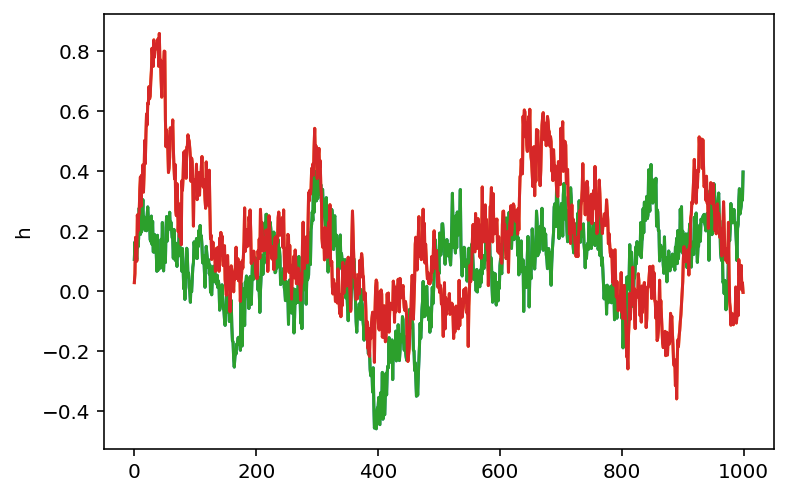

In [14]:
y = sp3.mcmc_results.posterior["h"][:, np.arange(0, 4000, 4), 20]
x = np.arange(y.shape[1])
ax = sns.lineplot(x=x, y=y[0, :])
sns.lineplot(x=x, y=y[1, :], ax=ax)
sns.lineplot(x=x, y=y[2, :], ax=ax)
sns.lineplot(x=x, y=y[3, :], ax=ax)
plt.show()

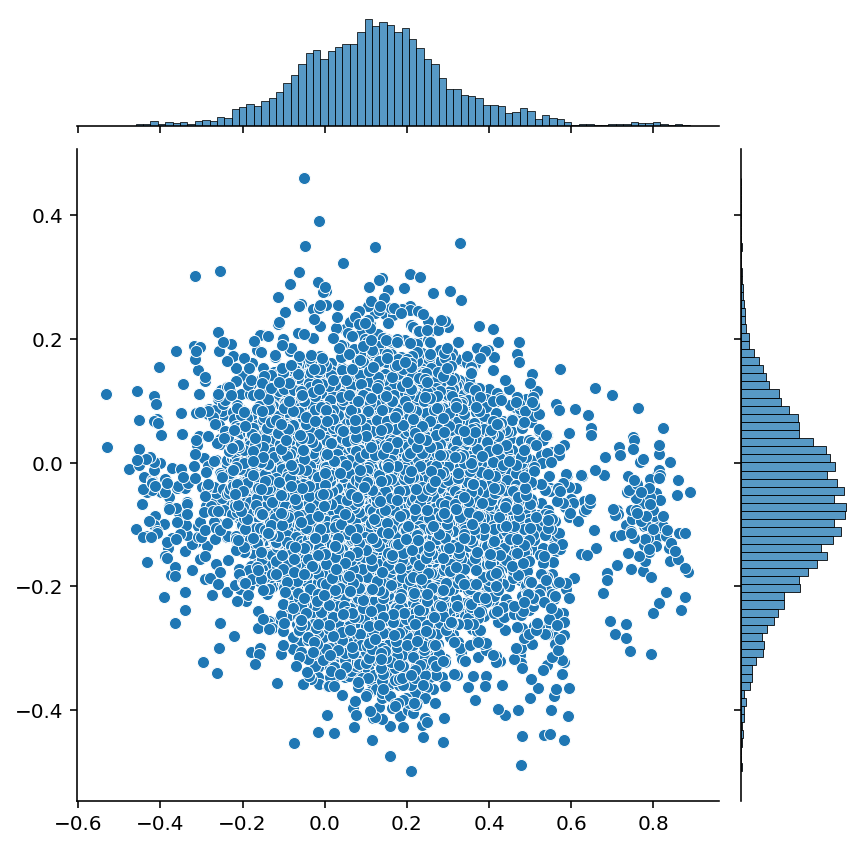

In [15]:
x = sp3.mcmc_results.posterior["h"][:, :, 20].values.flatten()
# y = sp3_kras.mcmc_results.posterior["σ_h"].values.flatten()
y = sp3.mcmc_results.posterior["g"][:, :, 20, 10].values.flatten()
sns.jointplot(x=x, y=y);

In [16]:
sp3_kras.mcmc_results.posterior["h"].shape

(4, 4000, 99)

---

In [ ]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

In [ ]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m